# CS5242 Final Project
> Dataset and rules

### Rules
- No additional data for training is allowed **except the pretrained models over ImageNet**. You need to submit your code for verification.
- Any cheating will result in 0 score. For example, joining the competition with multiple accounts; or using additional data.
- The dataset can only be used for this Kaggle competition. Distribution or using it for other purposes is not allowed.
- Set the teamname with your student number and your name, e.g., `A01234X_Bob`; Once your group is merged, rename the group to `Group_ID`, e.g., `Group_01`.
- Penalty will be applied if you merge into the group after the deadline (13 Oct, 17:00) or using improper group name. 10% off per day.

**Deadline**: 3 Nov, 17:00 <br>
**Report deadline**: 10 Nov, 17:00 <br>

### Imports and Settings

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import pandas as pd
from skimage.io import imread
from os import path

import torch
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
# for plotting figures (report)
import matplotlib
plt.style.use('ggplot')
%matplotlib inline
matplotlib.rcParams['figure.figsize'] = (3,3) # use larger for presentation
matplotlib.rcParams['font.size']= 9 # use 14 for presentation

In [3]:
# check for CUDA device and set default dtype
device = torch.device('cpu')
if torch.cuda.is_available():
    device = torch.device('cuda')
dtype = torch.float32
print(f'device: {device}\ndtype: {dtype}')

device: cpu
dtype: torch.float32


## Training Dataset (before Train/Val split)

In [4]:
# Paths to training dataset and labels (before Train/Val split)
train_csv = path.join('./datasets','train_label.csv')
train_data_path = path.join('./datasets','train_image','train_image')

- There are three classes (types of labels): {0, 1, 2}
- Input images are 8-bit (per channel) RGB images

Y: (1164, 2)
Y classes: [0 1 2]


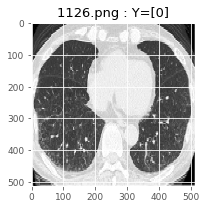

Check dtypes and size of sample input images:
 image # 1126-> shape(HxWxC): (512, 512, 3)| dtype: uint8
 image #  860-> shape(HxWxC): (512, 512, 3)| dtype: uint8
 image # 1130-> shape(HxWxC): (512, 512, 3)| dtype: uint8
 image # 1095-> shape(HxWxC): (512, 512, 3)| dtype: uint8
 image # 1044-> shape(HxWxC): (512, 512, 3)| dtype: uint8


In [5]:
# Training dataset labels
Y_train_np = pd.read_csv(train_csv).values
# We have three types of labels: {0, 1, 2},
# and 1164 samples (training dataset, before splitting into train/val data)
print('Y:',Y_train_np.shape)
print('Y classes:',np.unique(Y_train_np[:,1]))

np.random.seed(42) # RNG seed for consistency
ids = np.random.randint(0,Y_train_np.shape[0],size=(5,))

m=ids[0]
x_0 = imread(path.join(train_data_path,f'{m}.png'))
plt.imshow(x_0)
plt.title(f'{m}.png : Y={Y_train_np[Y_train_np[:,0]==m,1]}');
plt.show()
# dtype and shape of input images
print('Check dtypes and size of sample input images:')
for m in ids:
    x_0 = imread(path.join(train_data_path,f'{m}.png'))
    print(f' image #{m:5d}-> shape(HxWxC): {x_0.shape}| dtype: {x_0.dtype}') # HxWxC
# output was "shape(HxWxC): (512, 512, 3)| dtype: uint8"

## Using Pytorch Dataset Class (implemented in datautils.py)

In [6]:
from datautils import LoadTrainingData
from torchvision import transforms as T, utils

toPIL = T.ToPILImage()
transform = T.Compose([T.ToPILImage(),
                       T.Resize(224),
                       T.ToTensor(), 
                       T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
val_transform = T.Compose([T.ToPILImage(),
                           T.Resize(224),
                           T.ToTensor(), 
                           T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

# Paths to training dataset and labels (before Train/Val split)
train_csv = path.join('./datasets','train_label.csv')
train_data_path = path.join('./datasets','train_image','train_image')

np.random.seed(42) #seed np RNG for consistency
# split the original training data into 85% / 15% train/val datasets
datasets = LoadTrainingData(train_csv, train_data_path, transform=transform,
                            split=True, train_percent=85, val_transform=val_transform)

Displaying and converting normalized images back to \[0..1\] range (optionally, multiply by 255 and convert to uint to get original 8bit).
```python
from datautils import BatchUnnorm, Unnorm

unnorm = Unnorm() # unnormalize a single RGB image
unnormb = BatchUnnorm() # unnormalize batch of images

# example using batch
# can use PIL image instead of transpose below
toPIL = T.ToPILImage() #convert torch image to PIL image
for k, elem in enumerate(trainloader):
    grid = utils.make_grid(unnormb(elem['image']))# grid of images from the batch
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    
```

In [8]:
trainloader = DataLoader(datasets['train'], batch_size=4,shuffle=True, num_workers=0)
valloader = DataLoader(datasets['val'], batch_size=4,shuffle=False, num_workers=0)

Sample 0: x torch.Size([4, 3, 224, 224]); Labels [1, 1, 1, 1]


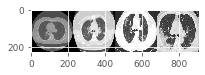

In [21]:
for k, elem in enumerate(trainloader):
    print(f'Sample {k}: x {elem["image"].shape}; Labels {elem["label"].tolist()}')
    grid = utils.make_grid(unnormb(elem['image']))
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    plt.show()
    break

Sample 0: x torch.Size([4, 3, 224, 224]); Labels [0, 1, 1, 0]


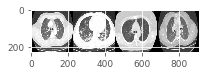

In [19]:
for k, elem in enumerate(valloader):
    print(f"Sample {k}: x {elem['image'].shape}; Labels {elem['label'].tolist()}")
    grid = utils.make_grid(unnormb(elem['image']))
    plt.imshow(grid.numpy().transpose((1, 2, 0)))
    plt.show()
    break